In [1]:
import pandas as pd

df = pd.read_excel("https://github.com/matteosan1/finance_course/raw/refs/heads/develop/input_files/ois_2024_10_14.xlsx",
                   index_col="maturities")
print (df.head())

              quotes
maturities          
7D          3.414000
14D         3.295500
1M          3.229000
2M          3.209205
3M          3.127103


In [2]:
from datetime import date
from finmarkets import OvernightIndexSwap, TimeInterval

obs_date = date.today()
oiss = []
pillars = []
for i in range(len(df)):
  maturity = df.index[i]
  quote = df['quotes'][maturity]*0.01
  oiss.append(OvernightIndexSwap(1, obs_date, maturity, quote))

for i in range(len(df)):
  maturity = df.index[i]
  pillars.append(obs_date + TimeInterval(maturity))

In [7]:
from scipy.optimize import newton

class Bootstrap:
    def __init__(self, obs_date, objects):
        self.obs_date = obs_date
        self.objects = objects

    def objective_function(self, x, i, xs, curve, kwargs):
        pillars = [self.obs_date] + [self.objects[j].payment_dates[-1] for j in range(i+1)]
        c = curve(self.obs_date, pillars, [1] + xs + [x])
        return self.objects[i].npv(c, **kwargs)

    def run(self, curve, guess=1.0, kwargs={}):
        x = []    
        for i in range(len(self.objects)):
            res = newton(self.objective_function, guess, args=(i, x, curve, kwargs))
            x.append(res)
        return x

In [8]:
from finmarkets import DiscountCurve

bootstrap = Bootstrap(obs_date, oiss)
dfs = bootstrap.run(DiscountCurve)

discount_curve = DiscountCurve(obs_date, pillars, dfs)

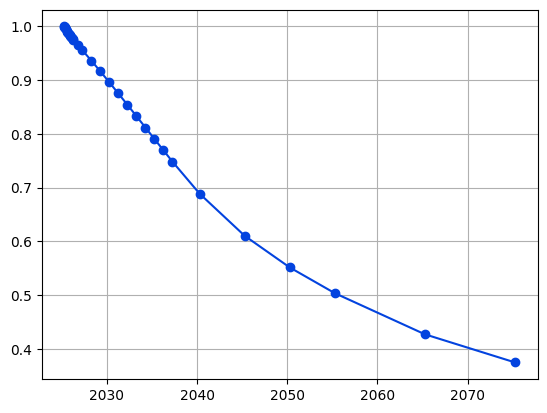

In [16]:
import matplotlib.pyplot as plt, numpy as np

plt.plot(discount_curve.pillar_dates, discount_curve.dfs, marker="o", color="xkcd:blue")
plt.grid(True)
plt.show()

In [10]:
import pandas as pd

from finmarkets import CreditDefaultSwap

obs_date = start_date = date.today()
mq = pd.read_excel("https://github.com/matteosan1/finance_course/raw/develop/input_files/cds_quotes.xlsx")

cdswaps = []
pillar_dates = []
for i in range (len(mq)):
    cds = CreditDefaultSwap (1e6, start_date, mq.loc[i, 'maturities'], mq.loc[i, 'quotes'])
    cdswaps.append(cds)
    pillar_dates.append(cds.payment_dates[-1])

In [12]:
from finmarkets import CreditCurve

bootstrap = Bootstrap(obs_date, cdswaps)
ndps = bootstrap.run(CreditCurve, kwargs={"dc":discount_curve})

credit_curve = CreditCurve(obs_date, pillar_dates, ndps)

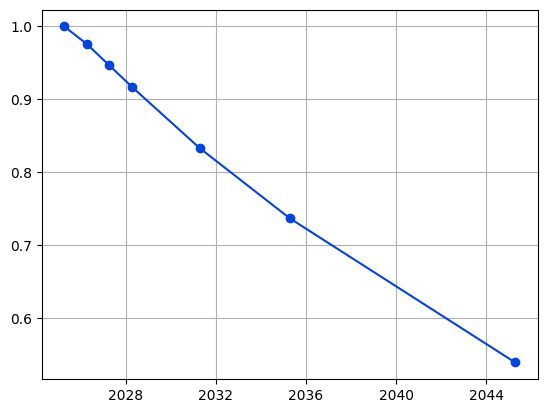

In [14]:
import matplotlib.pyplot as plt, numpy as np

plt.plot(credit_curve.pillar_dates, credit_curve.ndps, marker="o", color="xkcd:blue")
plt.grid(True)
plt.show()

In [20]:
print (f"OIS NPV: {100000:,.2f} EUR")

OIS NPV: 100,000.00 EUR
